# Exploração dos Dados

## Carregando o dataset

http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [59]:
# Pacotes importantes para este projeto
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
dfMovies = pd.read_csv("./ml-latest-small/movies.csv")
dfRatings = pd.read_csv("./ml-latest-small/ratings.csv")
dfTags = pd.read_csv("./ml-latest-small/tags.csv")
dfLinks = pd.read_csv("./ml-latest-small/links.csv")

# print("Movies:")
# print(dfMovies.head())
# print("Ratings:")
# print(dfRatings.head())
# print("Tags:")
# print(dfTags.head())
# print("Links:")
# print(dfLinks.head())

# Faz o merge do dataset utilizando os id's dos filmes como chave
dfMoviesRatings = pd.merge(dfMovies, dfRatings, on=['movieId'])

## Pré-processando os dados

In [4]:
# Separando os filmes e os títulos
moviesTitles = dfMoviesRatings[['movieId', 'title']]
moviesTitles = moviesTitles.set_index('movieId')
moviesTitles = moviesTitles.drop_duplicates()
moviesTitles.head()

# Remove colunas que não serão utilizadas no treinamento do sistema de recomendação
dfMoviesRatings = dfMoviesRatings.drop(['timestamp', 'userId', 'title'], 1)
print(dfMoviesRatings.head())

   movieId                                       genres  rating
0        1  Adventure|Animation|Children|Comedy|Fantasy     3.0
1        1  Adventure|Animation|Children|Comedy|Fantasy     4.0
2        1  Adventure|Animation|Children|Comedy|Fantasy     5.0
3        1  Adventure|Animation|Children|Comedy|Fantasy     2.0
4        1  Adventure|Animation|Children|Comedy|Fantasy     3.0


### Dados nulos ou faltantes

In [5]:
print("Movies - Null values: {}".format(dfMovies.isnull().any().any()))
print("Ratings - Null values: {}".format(dfRatings.isnull().any().any()))
print("Tags - Null values: {}".format(dfTags.isnull().any().any()))
print("Links - Null values: {}".format(dfLinks.isnull().any().any()))

Movies - Null values: False
Ratings - Null values: False
Tags - Null values: False
Links - Null values: True


### Análise e processamento das categorias

    Nesta etapa estou verificando quais as categorias que são encontradas no dataset:
    - categorias repetidas;
    - itens que não correspondem às categorias;

In [6]:
# Encontra todas as categorias presentes no dataset
dfCategories = dfMoviesRatings.genres.str.split(pat="|", expand=True)
dfCategories = Series(dfCategories.values.ravel()).unique()
dfCategories

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', None,
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'Documentary', 'IMAX', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [7]:
# Insere as colunas de cada categoria  
for col in dfCategories:
    dfMoviesRatings.insert(loc= len(dfMoviesRatings.columns), column=col, value=0)
dfMoviesRatings.head()

,movieId,genres,rating,Adventure,Animation,Children,Comedy,Fantasy,None,Romance,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Adventure|Animation|Children|Comedy|Fantasy,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Adventure|Animation|Children|Comedy|Fantasy,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Adventure|Animation|Children|Comedy|Fantasy,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Adventure|Animation|Children|Comedy|Fantasy,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Adventure|Animation|Children|Comedy|Fantasy,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# Transforma cada categoria em uma feature
count = 0
for i, row in dfMoviesRatings.iterrows():
    dfMoviesRatings.set_value(col=row[1].split(sep="|"), index=i, value=1)

dfMoviesRatings.head()

,movieId,genres,rating,Adventure,Animation,Children,Comedy,Fantasy,None,Romance,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Adventure|Animation|Children|Comedy|Fantasy,3.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Adventure|Animation|Children|Comedy|Fantasy,4.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Adventure|Animation|Children|Comedy|Fantasy,5.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Adventure|Animation|Children|Comedy|Fantasy,2.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Adventure|Animation|Children|Comedy|Fantasy,3.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Remove as categorias: None, '(no genres listed)'
dfMoviesRatings = dfMoviesRatings.drop([None, '(no genres listed)','genres'], 1)

#### Quais são as categorias que possuem relação entre si?

    Para verificar a relação entre as categorias é calculado a matriz de correlação, como apresentado na linha 4 da célula a seguir.
    
TODO: Detalhar as obsevações sobre as categorias

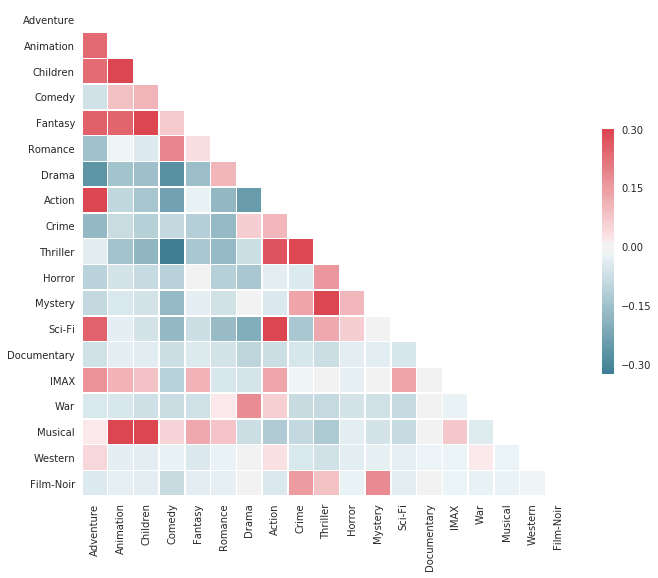

In [101]:
sns.set(style="white")

# Calcula a matriz de correlação das categorias
corr = dfMoviesRatings.drop(['movieId', 'rating'],1).corr()

# Gera uma máscara para a parte superior do triângulo
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Define a area de render do gráfico
f, ax = plt.subplots(figsize=(11, 9))

# Gera o colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Deseja o mapa de calor com a correlação entre as categorias
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Tags

    - Avaliar os tags mais comuns;
    - Existe relação das tags com as avaliações? Palavras positivas e negativas?

### Análise e processamento dos nomes dos filmes

    - Avaliar se existem nomes de um mesmo filme com escritas diferentes;
    - 

### Análise e processamentos dos ratings

    - Normalizar os valores;
    - Verificar a existência de outliers;
    - Verificar se a distribuição dos ratings é uniforme entre os filmes;

Algumas estatísticas:


count    9066.000000
mean       11.030664
std        24.050800
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       341.000000
dtype: float64

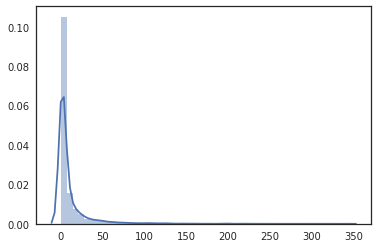

In [93]:
# Verifica o número de avaliações por filme
number_of_ratings_per_movie = pd.value_counts(dfMoviesRatings['movieId'].values, sort=False)

# Apresenta o gráfico com a distribuição o número de avaliações por filme
sns.distplot(pd.Series(number_of_ratings_per_movie, name=""))

# Algumas estatísticas
print('Algumas estatísticas:')
number_of_ratings_per_movie.describe()

## Conclusões

- Existe alguma relação entre a categoria do filme e a forma que ele é avaliado?


# Sistema de Recomendação

Idéias:
- Redução de dimensionalidade: utilizar auto-encoder ou PCA para reduzir número de features
- Clusterização para recomendações